In [56]:
from pymongo import MongoClient
import pandas as pd
from bson import json_util
from matplotlib import pyplot as plt
%matplotlib inline
from folium import Map,Marker
from folium.plugins import MarkerCluster

In [2]:
# Access DataBase
client = MongoClient()
db = client.get_database("companies")
comp = db.companies

# Creating the offices collection

In [3]:
res = comp.aggregate([
                      {"$unwind":"$offices" },
                      {"$match":{"offices.latitude":{"$ne":None}}},
                      {"$match":{"offices.longitude":{"$ne":None}}},
                      {"$project":{"_id":0}}])

In [4]:
db.companies_unwinded.insert_many(res)

In [5]:
offices = db.companies_unwinded

## Filter 1: startupfriendly

In [6]:
%run startupfriendly.ipynb
startupfriendly[0:3]

['NZL', 'GEO', 'CAN', 'SGP', 'HKG', 'JAM', 'AUS', 'AZE', 'ARM', 'UZB', 'XKX', 'MDA', 'EST', 'BRN', 'GBR', 'TWN', 'IRL', 'MUS', 'NOR', 'NLD']


['NZL', 'GEO', 'CAN']

## filter 2: Developpers want to be near startups

In [7]:
category_list = list(offices.find({},{'category_code':1, '_id':0}))
cat_values = [ele['category_code'] for ele in category_list]
print(set(cat_values))

{'social', 'travel', 'hardware', 'education', 'ecommerce', 'analytics', 'medical', 'biotech', 'local', 'real_estate', None, 'health', 'legal', 'photo_video', 'finance', 'software', 'games_video', 'public_relations', 'search', 'music', 'mobile', 'other', 'advertising', 'messaging', 'hospitality', 'fashion', 'nonprofit', 'enterprise', 'semiconductor', 'design', 'security', 'news', 'transportation', 'nanotech', 'sports', 'automotive', 'web', 'network_hosting', 'consulting', 'cleantech', 'manufacturing'}


Tech is an operational model more than a sector this means there could be tech companies in almost all sectors...


This means you could have tech companies within all category codes, example (legaltech companies on legal, fintech companies on finance)


So as crunchbase has a reputation for being a database specializd in tech companies, for that it makes sense to first assess the prominence os sectors where all the companies are tech companies (ex:web, software, mobile, advertising, enterprise etc...) using offices% as a proxy for the prominence of tech only sectors   

In [8]:
#is crunchbase a database specialised in tech companies?
companiesxcat = [[cat,
                  cat_values.count(cat),
                  ((cat_values.count(cat))/(len(cat_values)))*100
                 ] for cat in set(cat_values)]
cat_df = pd.DataFrame(companiesxcat)
cat_df=cat_df.rename(columns={0:'sector', 1:'count_off', 2:'off%'})
cat_df = cat_df.sort_values(by='off%',ascending=False)
print(cat_df.head(10))
print ("\nAs we can see in the Series below top 10 sectors in offices count are cominated by tech companies")
print (f" \nThis sectors account for {sum(cat_df['off%'][0:10])} of total  crunch database offices, so we can conclude crunchdb is specialised in tech companies and almost all the companies in the database are related to tech.")

             sector  count_off       off%
36              web      18456  21.294074
15         software      15080  17.398929
20           mobile       5456   6.294997
22      advertising       5432   6.267307
16      games_video       5152   5.944250
21            other       5000   5.768876
27       enterprise       4336   5.002769
38       consulting       3560   4.107440
4         ecommerce       3296   3.802843
37  network_hosting       3280   3.784382

As we can see in the Series below top 10 sectors in offices count are cominated by tech companies
 
This sectors account for 79.66586671589442 of total  crunch database offices, so we can conclude crunchdb is specialised in tech companies and almost all the companies in the database are related to tech.


## Calculating The number of tech startups that are near each potential office location

#### Creating the filter for tech startups

In [9]:
value_filter = {'total_money_raised':{'$gte':'$1000_000_000'},
                'deadpooled_day':None} #companies that are deadpooled are not counted
                
value_project = {'_id':1,
                 'name':1,
                 'offices.latitude':1,
                'offices.longitude':1}

tech_startups = offices.find(value_filter,value_project)
tech_list = list(tech_startups)
tech_list[0:5]

[{'_id': ObjectId('5fb2b8e81d0bca7750a902bd'),
  'name': 'Wetpaint',
  'offices': {'latitude': 47.603122, 'longitude': -122.333253}},
 {'_id': ObjectId('5fb2b8e81d0bca7750a902be'),
  'name': 'Wetpaint',
  'offices': {'latitude': 40.7237306, 'longitude': -73.9964312}},
 {'_id': ObjectId('5fb2b8e81d0bca7750a902c0'),
  'name': 'Digg',
  'offices': {'latitude': 37.764726, 'longitude': -122.394523}},
 {'_id': ObjectId('5fb2b8e81d0bca7750a902c2'),
  'name': 'Geni',
  'offices': {'latitude': 34.090368, 'longitude': -118.393064}},
 {'_id': ObjectId('5fb2b8e81d0bca7750a902c4'),
  'name': 'Gizmoz',
  'offices': {'latitude': 37.48413, 'longitude': -122.169472}}]

#### Creating a new collection for tech startups as  base for the geoqueries

In [107]:
res = comp.aggregate([
                      {"$unwind":"$offices" },
                      {"$match":{"offices.latitude":{"$ne":None}}},
                      {"$match":{"offices.longitude":{"$ne":None}}},
                      {"$match":{"offices.country_code":{"$in":startupfriendly[0:3]}}},
                      {"$match":{'deadpooled_day':None}},
                      {"$project":{"_id":0}}
])

db.top3.insert_many(res)
startups = db.top3

In [108]:
# Adding the coordinates to the Collection
res1 = startups.find({},{"offices":1}) #res es un iterador
for c in res1:
    filt = {"_id":c["_id"]}
    coord = {
              "type": "Point",
              "coordinates": [c["offices"]["longitude"], c["offices"]["latitude"]]
            }
    update = {"$set":{"coord":coord}}
    startups.update_one(filt,update)

In [109]:
scoord = [[c["offices"]["longitude"], c["offices"]["latitude"]] for c in list(startups.find())]
len(scoord)

456

In [110]:
target_ids = [list(startups.find({'coord':{'$near':{'$geometry':{'type':'Point', 'coordinates':c},"$maxDistance":1000}}},{'_id':1})) for c in scoord]

In [111]:
dev_attractivity = [[_id, target_ids.count(_id)] for _id in target_ids]

In [112]:
df_devpref = pd.DataFrame(dev_attractivity)
df_devpref = df_devpref.rename(columns={0:'_id', 1:'count_off'})
df_devpref = df_devpref.sort_values(by='count_off',ascending=False)
print(df_devpref)

                                                   _id  count_off
211  [{'_id': 5fbb5e6dd6feb44d924c0dfa}, {'_id': 5f...         22
431  [{'_id': 5fbb5e6dd6feb44d924c0dfa}, {'_id': 5f...         22
352  [{'_id': 5fbb5e6dd6feb44d924c0dfa}, {'_id': 5f...         22
37   [{'_id': 5fbb5e6dd6feb44d924c0dfa}, {'_id': 5f...         22
292  [{'_id': 5fbb5e6dd6feb44d924c0dfa}, {'_id': 5f...         22
..                                                 ...        ...
154  [{'_id': 5fbb5e6ed6feb44d924c0e7f}, {'_id': 5f...          1
153  [{'_id': 5fbb5e6ed6feb44d924c0e7e}, {'_id': 5f...          1
150  [{'_id': 5fbb5e6ed6feb44d924c0e7b}, {'_id': 5f...          1
149  [{'_id': 5fbb5e6ed6feb44d924c0e7a}, {'_id': 5f...          1
455  [{'_id': 5fbb5e6ed6feb44d924c0fac}, {'_id': 5f...          1

[456 rows x 2 columns]


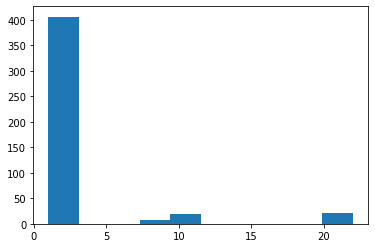

In [122]:
plt.hist(df_devpref['count_off']);

As we can see on the graph above there are 30 available locations that are at least than 500 m away from between 10 startups, and the others are quite disperse so, it makes sense to keep only the offices that are near at least 9 offices

In [115]:
df_devsel= df_devpref[df_devpref['count_off']>9]
len(df_devsel)

42

In [128]:
developpers_selection = [_id for _id in df_devsel['_id']]
developpers_selection[0:1]

[[{'_id': ObjectId('5fbb5e6dd6feb44d924c0dfa')},
  {'_id': ObjectId('5fbb5e6dd6feb44d924c0dfc')},
  {'_id': ObjectId('5fbb5e6dd6feb44d924c0e3f')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0ed3')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f94')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f86')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f45')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f34')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f32')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f0f')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0ecd')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0f09')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0ebe')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0eb8')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0e9c')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0e80')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0e5b')},
  {'_id': ObjectId('5fbb5e6dd6feb44d924c0e26')},
  {'_id': ObjectId('5fbb5e6ed6feb44d924c0e5a')},
  {'_id': ObjectId('5fbb5e6dd6feb44d924c0e24')},
  {'_id': ObjectId('

In [137]:
[ele[0]['_id'] for ele in developpers_selection]

dev_selected = [list(startups.find({'_id':ele[0]['_id']},{'_id':1,'coord':1})) for ele in developpers_selection]
dev_selected[0:2]

[[{'_id': ObjectId('5fbb5e6dd6feb44d924c0dfa'),
   'coord': {'type': 'Point', 'coordinates': [-79.386755, 43.670233]}}],
 [{'_id': ObjectId('5fbb5e6dd6feb44d924c0dfa'),
   'coord': {'type': 'Point', 'coordinates': [-79.386755, 43.670233]}}]]

In [146]:
folium = [[ele[0]['coord']['coordinates'][1],ele[0]['coord']['coordinates'][0]] for ele in dev_selected]

In [153]:
m = Map(location=[45.5017, -73.5673],zoom_start=3)

In [154]:
m

In [155]:
MarkerCluster(folium).add_to(m)

In [156]:
m